# **Setup**

### **Connect to Google Drive**

In [ ]:
from google.colab import drive, files

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = ""
DATASETS_PATH = PATH + "/datasets"
MODELS_PATH = PATH + "/models"

### **Install the required Python Libraries**

In [ ]:
!pip install -q kaggle

### **Import modules**

In [ ]:
import pandas as pd
import re
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from scipy.stats import pearsonr
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

from transformers import pipeline
from transformers import AutoTokenizer

# Data Exploration

## Upload Kaggle API key

In [ ]:
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d asaniczka/public-opinion-on-democrats-updated-daily

In [ ]:
!unzip public-opinion-on-democrats-updated-daily.zip

In [ ]:
# Read the actual CSV file name from the unzipped folder.
df = pd.read_csv('reddit_opinion_democrats.csv')

In [ ]:
# Print the total number of rows
print("Total number of rows:", df.shape[0])

## **Check for missing values**

In [ ]:
df.isna()

,comment_id,score,self_text,subreddit,created_time,post_id,author_name,controversiality,ups,downs,...,user_link_karma,user_comment_karma,user_total_karma,post_score,post_self_text,post_title,post_upvote_ratio,post_thumbs_ups,post_total_awards_received,post_created_time
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3542053,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3542054,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3542055,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3542056,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [ ]:
df.isna().sum()

,0
comment_id,0
score,0
self_text,14
subreddit,0
created_time,0
post_id,0
author_name,0
controversiality,0
ups,0
downs,0


## **Check for duplicated values**

In [ ]:
df.duplicated().sum()

0

## **Create a dataframe that takes data uptil November 5th, 2024 00:00:00**

In [ ]:
df['created_time'] = pd.to_datetime(df['created_time'])

pre_elections_df = df[df['created_time'] <= '2024-11-05 00:00:00']
pre_elections_df.head()

,comment_id,score,self_text,subreddit,created_time,post_id,author_name,controversiality,ups,downs,...,user_link_karma,user_comment_karma,user_total_karma,post_score,post_self_text,post_title,post_upvote_ratio,post_thumbs_ups,post_total_awards_received,post_created_time
344675,lvfs75p,86,“Go back to (South) Africa!”,politics,2024-11-04 23:59:49,1gjmm0s,JacqueOffAllTrades,0,86,0,...,9.0,3237.0,3246.0,32653,NaN,"Tucker Carlson warns Elon Musk ""will be destroyed"" if Kamala Harris wins",0.92,32653,0,2024-11-04 19:17:36
344676,lvfs71e,11,![gif](giphy|KnDiq8fqN3UzK),trump,2024-11-04 23:59:48,1gjjhee,ragandy89,0,11,0,...,21256.0,42096.0,68010.0,938,NaN,This is what Reddit liberals think actually happens 🤣,0.84,938,0,2024-11-04 17:11:52
344677,lvfs5de,2,I opened the article and was a little dumbstruck. \n\nI guess we will see tomorrow but that’s not great for him,politics,2024-11-04 23:59:32,1gjg7tn,anonononnnnnaaan,0,2,0,...,1276.0,23535.0,24811.0,3100,NaN,Donald Trump's Hometown Stronghold Endorses Kamala Harris,0.97,3100,0,2024-11-04 14:57:53
344678,lvfs5ae,-4,The Liberals are so stupid to believe their social media platforms and mainstream broadcast media. That's not truly representative of America.\n\nIdeally there will be a mass exodus of those losers out of the USA.,Republican,2024-11-04 23:59:31,1gjpb0c,BrandDC,1,-4,0,...,4089.0,37417.0,41739.0,489,"This is the first time I've ever early voted. There's quite a few people there at the courthouse today...\n\n I don't know, man, I just... I'm really nervous, and anxious.. the vitriol of the Biden/Harris administration is abominable, and Kamala Harris is nothing but a puppet for the military industrial complex and the New World Order.\n\nAs a follower of Jesus Christ, in our faith, we do believe that no matter what happens, Jesus is still King of kings and Lord of lords, He will still rescue his church, and punish the wicked..\n\nBut even then, Christians still have doubts and worries.",Just voted for Donald Trump.,0.81,489,0,2024-11-04 21:07:43
344679,lvfs4zb,2,panicky detail profit abundant slimy shocking boat obtainable dazzling psychotic\n\n *This post was mass deleted and anonymized with [Redact](https://redact.dev/home)*,politics,2024-11-04 23:59:28,1gjjbph,DastardDante,0,2,0,...,51.0,28569.0,28620.0,0,NaN,Biden Ends 2024 Race Having Done Just One Campaign Event with Harris,0.18,0,0,2024-11-04 17:05:29


## **Extract the day, month and year from the comment creation date**

In [ ]:
pre_elections_df['day'] = pre_elections_df['created_time'].dt.day
pre_elections_df['month'] = pre_elections_df['created_time'].dt.month
pre_elections_df['year'] = pre_elections_df['created_time'].dt.year

pre_elections_df.head()

## **Get the count of unique subreddits**

In [ ]:
unique_subreddit = pre_elections_df['subreddit'].unique()
print('Unique Subreddits: ', unique_subreddit)

subreddit_counts = pre_elections_df['subreddit'].value_counts()
print('Count of Subreddits: \n', subreddit_counts)

Unique Subreddits:  ['politics' 'trump' 'Republican' 'WhitePeopleTwitter' 'Conservative'
 'democrats' 'conspiracy' 'conservatives' 'Libertarian' 'VoteDEM'
 'neoliberal' 'AskThe_Donald' 'PoliticalHumor' 'WayOfTheBern'
 'changemyview' 'ShitPoliticsSays' 'Political_Revolution'
 'Republican_misdeeds' 'SandersForPresident' 'uspolitics'
 'RepublicanValues' 'AskReddit' 'ConservativesOnly' 'EnoughTrumpSpam'
 'news' 'progressive' 'republicanmemes' 'Republican_memes'
 'ChristianDemocrat' 'ConservativeDemocrat']
Count of Subreddits: 
 subreddit
politics                1362320
neoliberal               346433
conspiracy               279086
changemyview             255891
Conservative             212070
VoteDEM                  132473
WhitePeopleTwitter       116931
democrats                109856
PoliticalHumor            54480
WayOfTheBern              47263
Republican                44291
trump                     34405
Libertarian               30174
conservatives             28840
news        

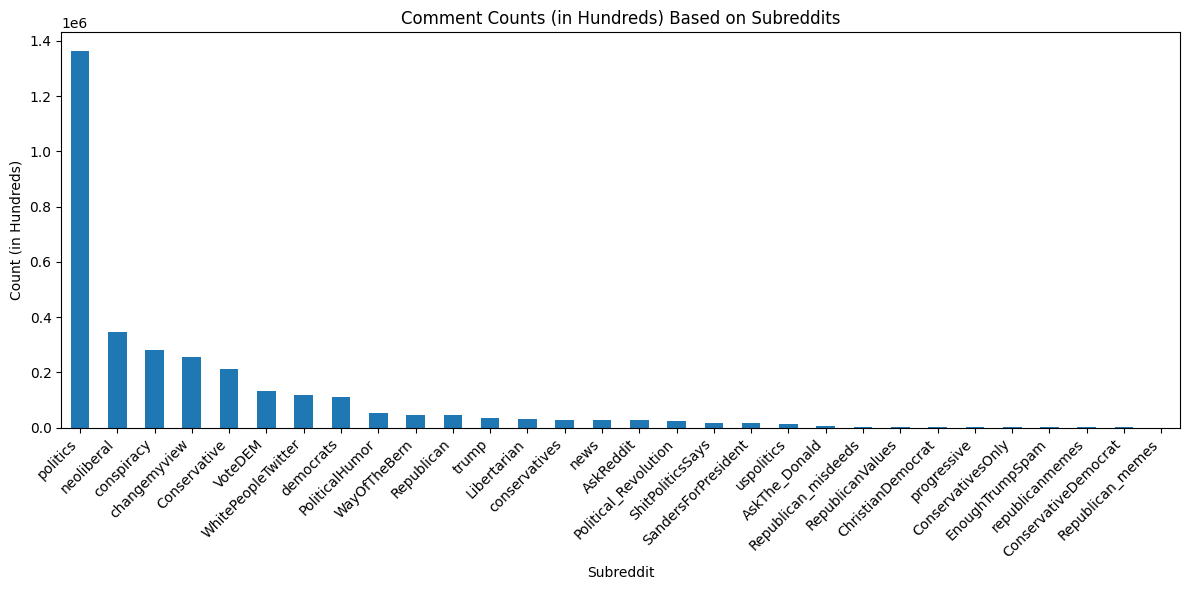

In [ ]:
# Create a bar plot
plt.figure(figsize=(12, 6))
subreddit_counts.plot(kind='bar')

# Customize the plot
plt.title('Comment Counts (in Hundreds) Based on Subreddits')
plt.xlabel('Subreddit')
plt.ylabel('Count (in Hundreds)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

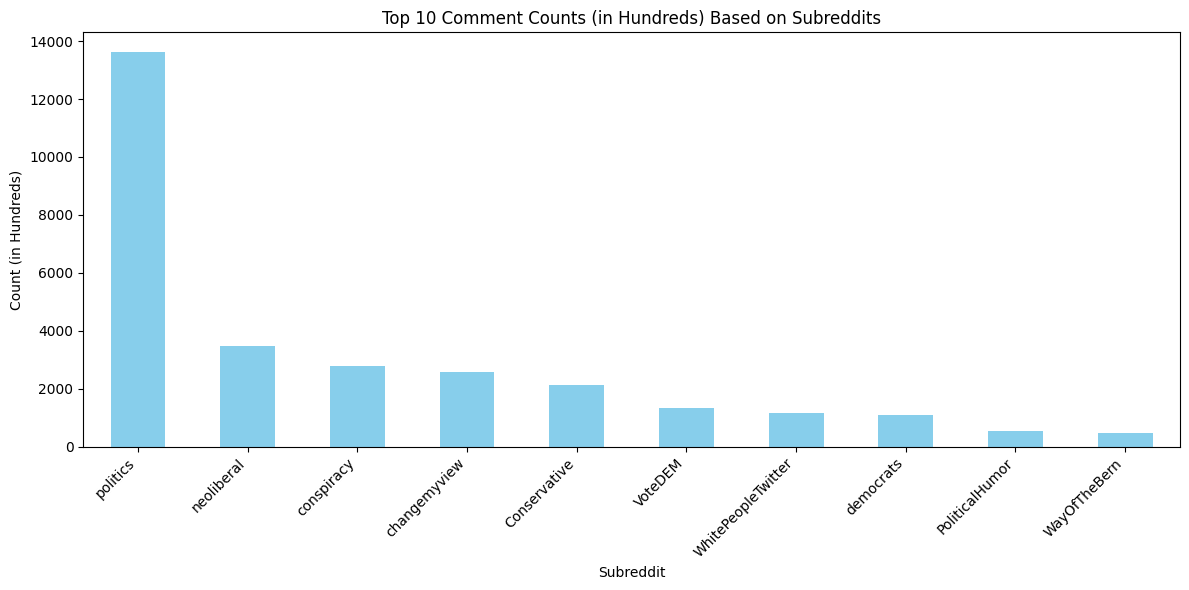

In [ ]:
subreddit_counts_in_hundreds = subreddit_counts / 100

# Bar plot
plt.figure(figsize=(12, 6))
subreddit_counts_in_hundreds[:10].plot(kind='bar', color='skyblue')

# Customize the plot
plt.title('Top 10 Comment Counts (in Hundreds) Based on Subreddits')
plt.xlabel('Subreddit')
plt.ylabel('Count (in Hundreds)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

## **Create a dataframe that only has data from the 'politics' subreddit uptil November 5th, 2024**

In [ ]:
politics_df = pre_elections_df[pre_elections_df['subreddit'] == 'politics']
politics_df.head()

,comment_id,score,self_text,subreddit,created_time,post_id,author_name,controversiality,ups,downs,...,post_score,post_self_text,post_title,post_upvote_ratio,post_thumbs_ups,post_total_awards_received,post_created_time,day,month,year
344675,lvfs75p,86,“Go back to (South) Africa!”,politics,2024-11-04 23:59:49,1gjmm0s,JacqueOffAllTrades,0,86,0,...,32653,NaN,"Tucker Carlson warns Elon Musk ""will be destroyed"" if Kamala Harris wins",0.92,32653,0,2024-11-04 19:17:36,4,11,2024
344677,lvfs5de,2,I opened the article and was a little dumbstruck. \n\nI guess we will see tomorrow but that’s not great for him,politics,2024-11-04 23:59:32,1gjg7tn,anonononnnnnaaan,0,2,0,...,3100,NaN,Donald Trump's Hometown Stronghold Endorses Kamala Harris,0.97,3100,0,2024-11-04 14:57:53,4,11,2024
344679,lvfs4zb,2,panicky detail profit abundant slimy shocking boat obtainable dazzling psychotic\n\n *This post was mass deleted and anonymized with [Redact](https://redact.dev/home)*,politics,2024-11-04 23:59:28,1gjjbph,DastardDante,0,2,0,...,0,NaN,Biden Ends 2024 Race Having Done Just One Campaign Event with Harris,0.18,0,0,2024-11-04 17:05:29,4,11,2024
344682,lvfs45n,13,"Don't forget honorary, irrelevance chorus member Megyn Kelly.",politics,2024-11-04 23:59:20,1gjmm0s,MoreMetaFeta,0,13,0,...,32653,NaN,"Tucker Carlson warns Elon Musk ""will be destroyed"" if Kamala Harris wins",0.92,32653,0,2024-11-04 19:17:36,4,11,2024
344684,lvfs2o3,12,"I still need to watch the Buttigieg video sometime, but on the topic of Obama not codifying Roe, I think there is something he said that critics like to point out about it not being a priority. The thing about it was I'm sure he would have signed it into law if a bill arrived on his desk, but it wasn't likely. So the priority was weighing how much political capital he wanted to use on something (a bunch of democrats in congress would have been really reluctant or outright opposed to it).",politics,2024-11-04 23:59:06,1gjm3v4,hard-time-on-planet,0,12,0,...,5041,NaN,Pete Buttigieg debates 25 undecided Michigan voters on why Kamala Harris is better,0.98,5041,0,2024-11-04 18:57:26,4,11,2024


## **Create a dataframe that only has data from the 'politics' subreddit from 2024**

In [ ]:
pre_elections_2024_df = politics_df[politics_df['year'] == 2024]

In [ ]:
# Counts of comments based on the month
monthly_counts = pre_elections_2024_df['month'].value_counts() / 10000

# Sort by the index (month)
monthly_counts = monthly_counts.sort_index()

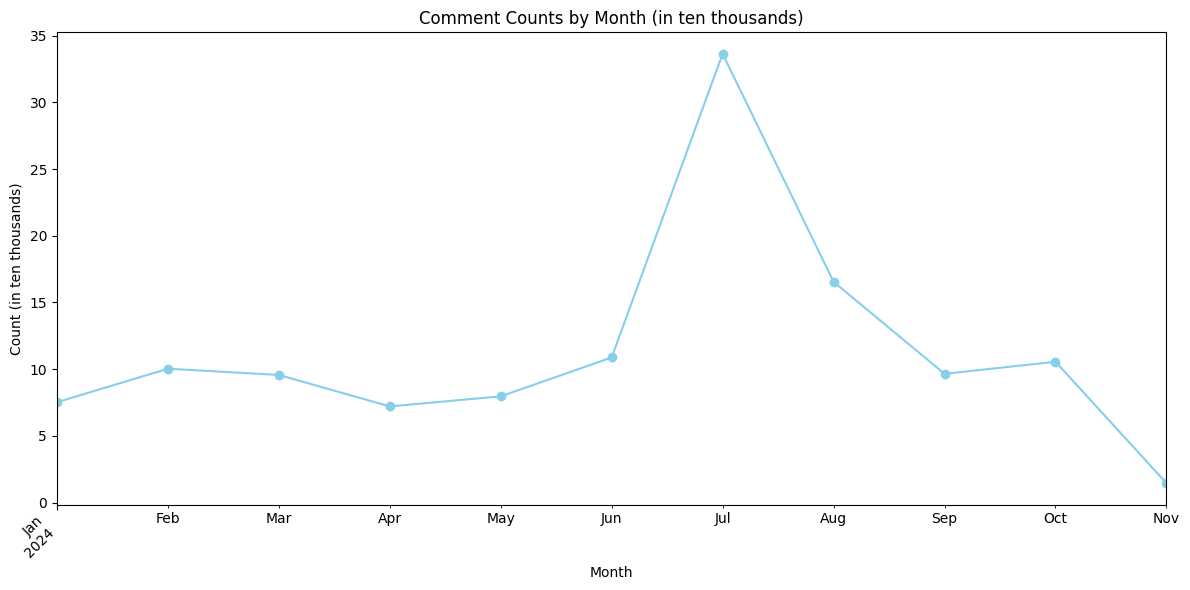

In [ ]:
months = monthly_counts.index.astype(int).map({
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'
})

monthly_counts.index = pd.to_datetime(monthly_counts.index.astype(str) + '-2024', format='%m-%Y')

# Sort the data by month
monthly_counts = monthly_counts.sort_index()

# Create a line plot
plt.figure(figsize=(12, 6))
monthly_counts.plot(kind='line', marker='o', color='skyblue')

# Customize the plot
plt.title('Comment Counts by Month (in ten thousands)')
plt.xlabel('Month')
plt.ylabel('Count (in ten thousands)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

## **Most Engaging Day of The Most Engaging Month**

In [ ]:
# Find the month with the maximum comment count
max_month = monthly_counts.idxmax()

# Extract the month and year from the index
max_month_str = max_month.strftime('%Y-%m')
max_month_int = int(max_month.strftime('%m'))
max_year_int = int(max_month.strftime('%Y'))

# Filter the DataFrame for the month with the maximum comment count
max_month_df = pre_elections_2024_df[(pre_elections_2024_df['month'] == max_month_int)
                                        & (pre_elections_2024_df['year'] == max_year_int)]

# Group by day and count comments
daily_counts = max_month_df.groupby('day')['day'].count()

# Create a DataFrame for daily counts
daily_counts_df = pd.DataFrame({'day': daily_counts.index, 'comment_count': daily_counts.values})

# Print the DataFrame
print(f"Daily comment counts for the month with the highest comment count ({max_month_str}):")
daily_counts_df

Daily comment counts for the month with the highest comment count (2024-07):


,day,comment_count
0,1,10096
1,2,11732
2,3,14988
3,4,11447
4,5,10772
5,6,12179
6,7,9545
7,8,13182
8,9,12201
9,10,12400


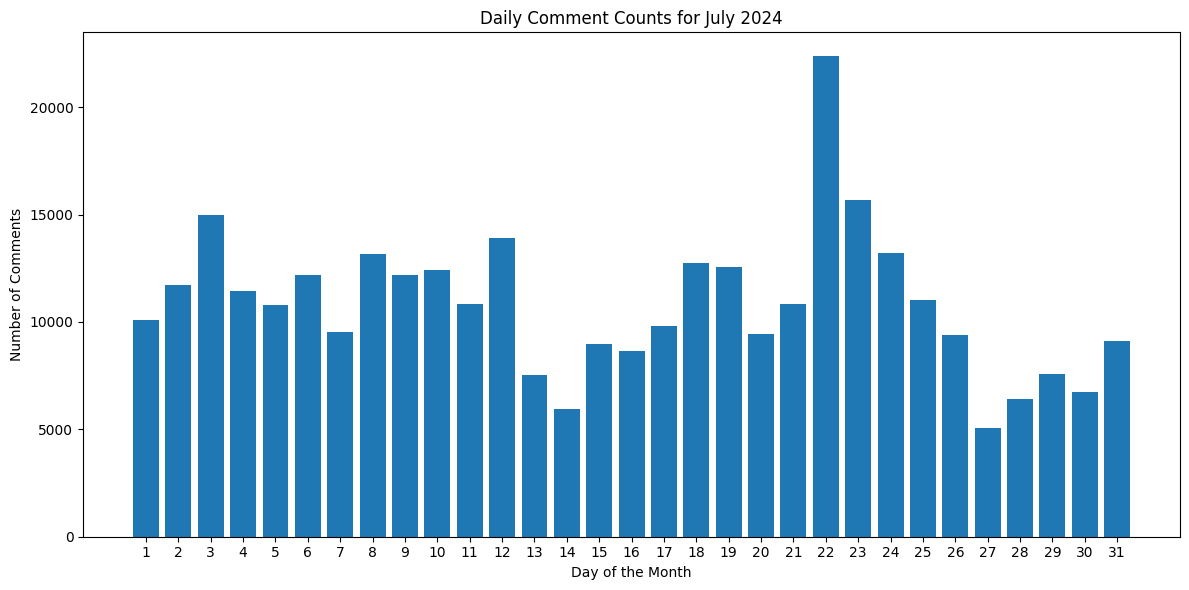

In [ ]:
# Create a bar plot of daily counts
plt.figure(figsize=(12, 6))
plt.bar(daily_counts.index, daily_counts.values)

# Customize the plot
plt.title(f'Daily Comment Counts for {max_month.strftime("%B %Y")}')
plt.xlabel('Day of the Month')
plt.ylabel('Number of Comments')
plt.xticks(daily_counts.index)  # Ensure all days are shown on the x-axis
plt.tight_layout()
plt.show()

In [ ]:
# Find the day with the maximum comment count in the month with the maximum comments
max_day = daily_counts.idxmax()

# Filter the data for the specific day with the maximum comments
max_day_data = max_month_df[max_month_df['created_time'].dt.day == max_day]

# Now max_day_data contains only the comments from the day with the highest comment count
# within the month that had the highest overall comment count.
print(f"\nComments from the day with the maximum comments in {max_month.strftime('%B %Y')}:")
max_day_data


Comments from the day with the maximum comments in July 2024:


,comment_id,score,self_text,subreddit,created_time,post_id,author_name,controversiality,ups,downs,...,post_score,post_self_text,post_title,post_upvote_ratio,post_thumbs_ups,post_total_awards_received,post_created_time,day,month,year
1376473,legs5cp,8,"Kelly has the most broad moderate/undecided appeal of any candidates, that’s what he has going for him. Former military, former goddamn ASTRONAUT, has first-hand experience with the results of gun violence while not being crazy about gun control.\n\nI feel the other picks are more geographically strong if targeting a specific region or state, especially Shapiro if going for PA. But Kelly I think is the strongest pick across the board for the general country.\n\nPersonally I like Kelly the most but not confident enough to say it’s the smartest choice. I completely agree with your point about PA and their total vote count.",politics,2024-07-22 23:59:58,1e9ol1d,Local-Bid5365,0,8,0,...,299,NaN,Pennsylvania Gov. Josh Shapiro keeps the door open to being Kamala Harris' VP pick,0.91,299,0,2024-07-22 20:31:12,22,7,2024
1376475,legs4xg,8,"My attitude about voting for Biden was he's old, if he drops dead, Kamala will be right there.",politics,2024-07-22 23:59:53,1e9lujc,RumandDiabetes,0,8,0,...,7770,NaN,Kamala Harris Is Already a Fundraising Powerhouse,0.96,7770,0,2024-07-22 18:41:08,22,7,2024
1376477,legs43f,1,"Like Delroy Lindo decried; just say the word. You want to, just do it. It's a free country, I'll even say it with you",politics,2024-07-22 23:59:45,1e9myoo,gsnyder70,0,1,0,...,791,NaN,Using DEI to Attack Kamala Harris Is a Great Idea—If Republicans Want to Lose,0.94,791,0,2024-07-22 19:26:26,22,7,2024
1376478,legs406,2,So he’s saying he only serves in government for the future well-being of his children and not the nation as a whole. Sounds selfish.,politics,2024-07-22 23:59:44,1e9sq2i,MatrimCauthon95,0,2,0,...,0,NaN,JD Vance Dismisses Kamala Harris As 'Childless Cat Lady',0.44,0,0,2024-07-22 23:22:46,22,7,2024
1376483,legs2c0,6,I’m curious why you feel that way? Kelly will be replaced with another democrat in AZ. I’d much rather have him in the White House doing good things for ALL the states!,politics,2024-07-22 23:59:27,1e9nruy,Soul_Muppet,0,6,0,...,281,NaN,The reason to tap Mark Kelly for VP that no one's talking about,0.92,281,0,2024-07-22 19:59:10,22,7,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1415350,leb0uhd,9,I stand double corrected,politics,2024-07-22 00:00:23,1e8yro3,Keunster,0,9,0,...,5869,NaN,Stop panicking. Replacing Biden on ballots isn't a problem.,0.93,5869,0,2024-07-21 22:42:51,22,7,2024
1415352,leb0u8l,4,There isn't time for a process. The election is in 100 days.,politics,2024-07-22 00:00:20,1e901ie,emeybee,0,4,0,...,283,NaN,Here's Who Has Endorsed Kamala Harris for President So Far,0.94,283,0,2024-07-21 23:41:32,22,7,2024
1415353,leb0u08,5,&gt; All facts here\n\nall i see is opinions.,politics,2024-07-22 00:00:18,1e8yyes,squintytoast,0,5,0,...,0,NaN,It's Been Easy To Forget How Bad Kamala Harris Is,0.10,0,0,2024-07-21 22:51:28,22,7,2024
1415356,leb0t9u,2,"The argument about her “likability” is misogynistic and intolerant. \n\n*You are allowed to be offended, and you are allowed to lecture, and you are allowed to be responded to with correction.*\n\nYou’re welcome ✅",politics,2024-07-22 00:00:10,1e8xjjb,MaxwellUsheredin,0,2,0,...,136,NaN,"Democrats Praise Biden’s Exit, Though Some Are Silent on Harris",0.70,136,0,2024-07-21 21:47:15,22,7,2024


In [ ]:
# Group by 'post_title' and sum the 'score' for each unique title within max_day_data
title_scores = max_day_data.groupby('post_title')['score'].sum()

# Sort the title scores in descending order
title_scores_sorted = title_scores.sort_values(ascending=False)

# Create a new DataFrame with the sorted title scores, post IDs, and the sum of scores
result_df = pd.DataFrame({
    'post_title': title_scores_sorted.index,
    'total_score': title_scores_sorted.values
})

# Add the post_id to the result dataframe
post_ids = []
for title in result_df['post_title']:
    post_ids.append(max_day_data[max_day_data['post_title'] == title]['post_id'].iloc[0])
result_df['post_id'] = post_ids

result_df

,post_title,total_score,post_id
0,MAGA world is really mad that Trump is no longer running against Biden,107950,1e992oo
1,Trump and J.D. Vance Lose Their Minds Over Kamala Harris “Coup” - Donald Trump and his fellow Republicans are panicking over Joe Biden dropping out of the 2024 race.,93511,1e9hky4
2,Biden’s exit leads to the biggest day for Democratic donations online in years — $30 million and counting.,87565,1e90imp
3,Sen. Mark Kelly of Arizona Emerges As Unexpected VP Candidate For Kamala Harris,84040,1e9no14
4,Donald Trump's Chances of Winning Election Decline After Biden Drops Out,81676,1e9ecrq
...,...,...,...
318,"Many Black and Hispanic Democrats Hold Firm for Biden, Eyeing Harris’s Future",-3,1e8r8mb
319,DNC members are organizing a letter backing Kamala Harris,-5,1e8w96v
320,Biden and his team reach the right decision,-9,1e9gnuv
321,RFK Jr. reinforces possibility of winning 2024 after Biden drops out,-19,1e8ybsq


In [ ]:
# Sort the DataFrame by total_score in descending order and get the top 10 rows
top_10_titles = result_df.sort_values(by='total_score', ascending=False).head(10)

# Print the top 10 titles and their total scores
top_10_titles

,post_title,total_score,post_id
0,MAGA world is really mad that Trump is no longer running against Biden,107950,1e992oo
1,Trump and J.D. Vance Lose Their Minds Over Kamala Harris “Coup” - Donald Trump and his fellow Republicans are panicking over Joe Biden dropping out of the 2024 race.,93511,1e9hky4
2,Biden’s exit leads to the biggest day for Democratic donations online in years — $30 million and counting.,87565,1e90imp
3,Sen. Mark Kelly of Arizona Emerges As Unexpected VP Candidate For Kamala Harris,84040,1e9no14
4,Donald Trump's Chances of Winning Election Decline After Biden Drops Out,81676,1e9ecrq
5,"Kamala Harris raises $50 million on first day of campaign, inciting what ‘might be the greatest fundraising moment in Democratic Party history’",52899,1e9key9
6,Donald Trump Losing to Kamala Harris in Three National Polls,47969,1e9roq9
7,Trump and His Allies Are Freaking Out Over Biden Leaving Race,45598,1e9fj9j
8,Biden flips the script — and Republicans forget their lines,35521,1e9dpq2
9,‘It’s Gonna Take a Civil War’: Trump Campaign Speaker Warns of Violence if Dems Win,35216,1e9opu3


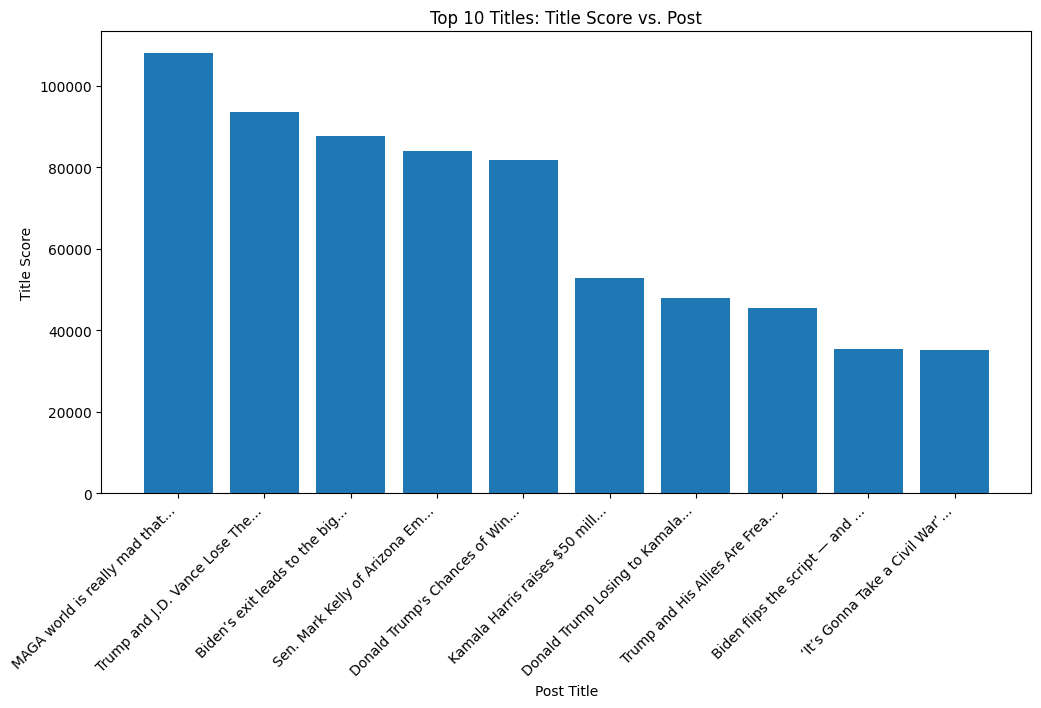

In [ ]:
def trim_string(string):
    return string[:29] + '...'

top_10_titles['post_title_shortened'] = top_10_titles['post_title'].apply(trim_string)

plt.figure(figsize=(12, 6))
plt.bar(top_10_titles['post_title_shortened'], top_10_titles['total_score'])
plt.xlabel("Post Title")
plt.ylabel("Title Score")
plt.title("Top 10 Titles: Title Score vs. Post")
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# Print the top 3 post titles completely
for i in range(min(3, len(result_df))):  # Handle cases where there are fewer than 3 titles
    print(result_df['post_title'][i])

MAGA world is really mad that Trump is no longer running against Biden
Trump and J.D. Vance Lose Their Minds Over Kamala Harris “Coup” - Donald Trump and his fellow Republicans are panicking over Joe Biden dropping out of the 2024 race.
Biden’s exit leads to the biggest day for Democratic donations online in years — $30 million and counting.


# Sentiment Exploration on non-cleaned data

## Influential Users

In [ ]:
print('Lowest Score: ', pre_elections_2024_df["score"].min())
print('Highest Score: ', pre_elections_2024_df["score"].max())

Lowest Score:  -308
Highest Score:  22498


In [ ]:
# Identify influential users based on karma
# sorting users by their total karma to identify influential users
influential_users = pre_elections_2024_df.groupby('author_name').agg({
    'user_total_karma': 'first',
    'user_comment_karma': 'first',
    'user_link_karma': 'first',
    'user_awardee_karma': 'first',
    'user_awarder_karma': 'first',
    'ups': 'sum',
    'downs': 'sum',
    'score': 'sum',
    'controversiality': 'mean'
}).reset_index()

influential_users.fillna(0)

,author_name,user_total_karma,user_comment_karma,user_link_karma,user_awardee_karma,user_awarder_karma,ups,downs,score,controversiality
0,*polhold00772,0.0,0.0,0.0,0.0,0.0,41,0,41,0.000000
1,-------7654321,130096.0,77815.0,52281.0,0.0,0.0,1508,0,1508,0.083333
2,------_---__-Sad,1493.0,1428.0,65.0,0.0,0.0,37,0,37,0.000000
3,----Dongers,69420.0,68854.0,278.0,288.0,0.0,1781,0,1781,0.092308
4,----JZ----,25740.0,23309.0,2431.0,0.0,0.0,10,0,10,0.000000
...,...,...,...,...,...,...,...,...,...,...
162547,zzxxxzzzxxxzz,24534.0,24329.0,205.0,0.0,0.0,182,0,182,0.142857
162548,zzy335,90170.0,89922.0,77.0,157.0,14.0,243,0,243,0.000000
162549,zzyul,89015.0,88460.0,6.0,549.0,0.0,431,0,431,0.000000
162550,zzyzx2,49674.0,33508.0,15972.0,161.0,33.0,1,0,1,0.000000


In [ ]:
# Sort influential users by total karma to focus on the most influential ones
influential_users = influential_users.sort_values(by='user_total_karma', ascending=False)

# Display the top 10 most influential users
print("Top 10 Most Influential Users in Democrats Discussions:")
print(influential_users.head(10))

# Analyze Engagement Patterns for Influential Users
# Select the top 10 influential users
top_influential_users = influential_users.head(10)['author_name']

# Filter comments by these top users in the Democrats-related data
top_user_comments = pre_elections_2024_df[pre_elections_2024_df['author_name'].isin(top_influential_users)]

# Calculate average engagement metrics for these top users
user_engagement_patterns = top_user_comments.groupby('author_name').agg({
    'ups': 'mean',
    'downs': 'mean',
    'score': 'mean',
    'controversiality': 'mean',
    'user_total_karma': 'first',
    'user_comment_karma': 'first'
}).reset_index()

Top 10 Most Influential Users in Democrats Discussions:
                 author_name  user_total_karma  user_comment_karma  \
77152              Sariel007        16714613.0            848569.0   
10377             BelleAriel        15224855.0            868025.0   
134973            mike_pants         9984187.0           3380389.0   
162460              zsreport         9457935.0           1089304.0   
66572              Palifaith         6253290.0           1944277.0   
8048              AudibleNod         6040983.0           3519493.0   
72268        RamsesThePigeon         5329800.0           4810120.0   
142917            progress18         5161374.0            446672.0   
9365    Balls_of_Adamanthium         5157622.0           2684738.0   
69016   PoliticsModeratorBot         4808760.0              -100.0   

        user_link_karma  user_awardee_karma  user_awarder_karma    ups  downs  \
77152        15697469.0            149281.0             19294.0   2290      0   
10377      


Engagement Patterns for Top Influential Users:
            author_name         ups  downs       score  controversiality  \
0            AudibleNod  320.849315    0.0  320.849315          0.082192   
1  Balls_of_Adamanthium   16.333333    0.0   16.333333          0.000000   
2            BelleAriel   54.263158    0.0   54.263158          0.000000   
3             Palifaith  211.733333    0.0  211.733333          0.000000   
4  PoliticsModeratorBot    2.615385    0.0    2.615385          0.038462   
5       RamsesThePigeon    9.000000    0.0    9.000000          0.000000   
6             Sariel007   50.888889    0.0   50.888889          0.000000   
7            mike_pants  175.281250    0.0  175.281250          0.031250   
8            progress18  356.500000    0.0  356.500000          0.000000   
9              zsreport  144.194346    0.0  144.194346          0.017668   

   user_total_karma  user_comment_karma  
0         6040983.0           3519493.0  
1         5157622.0           2

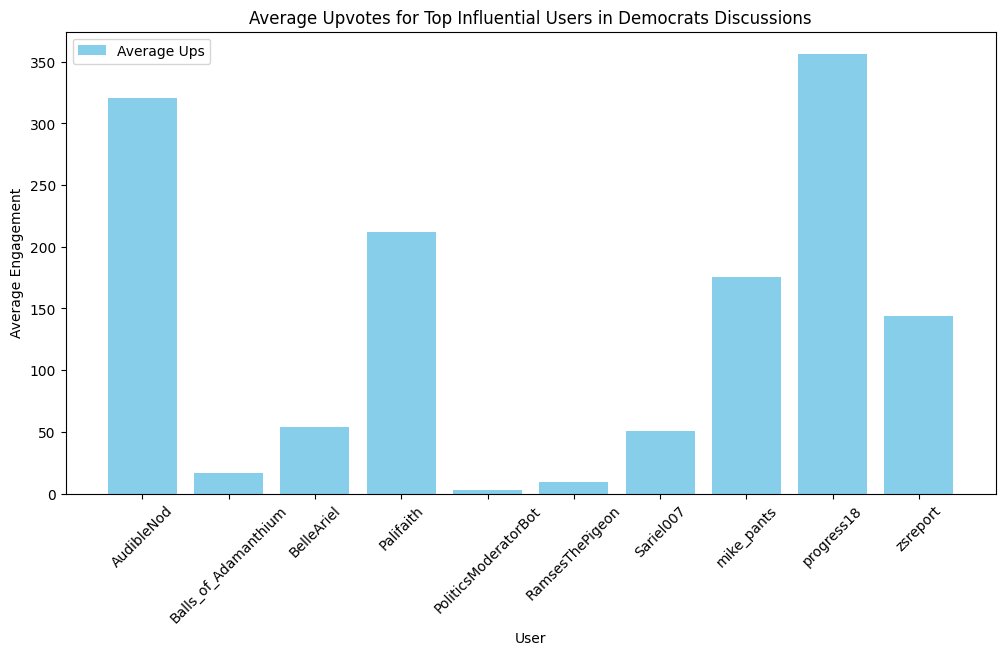

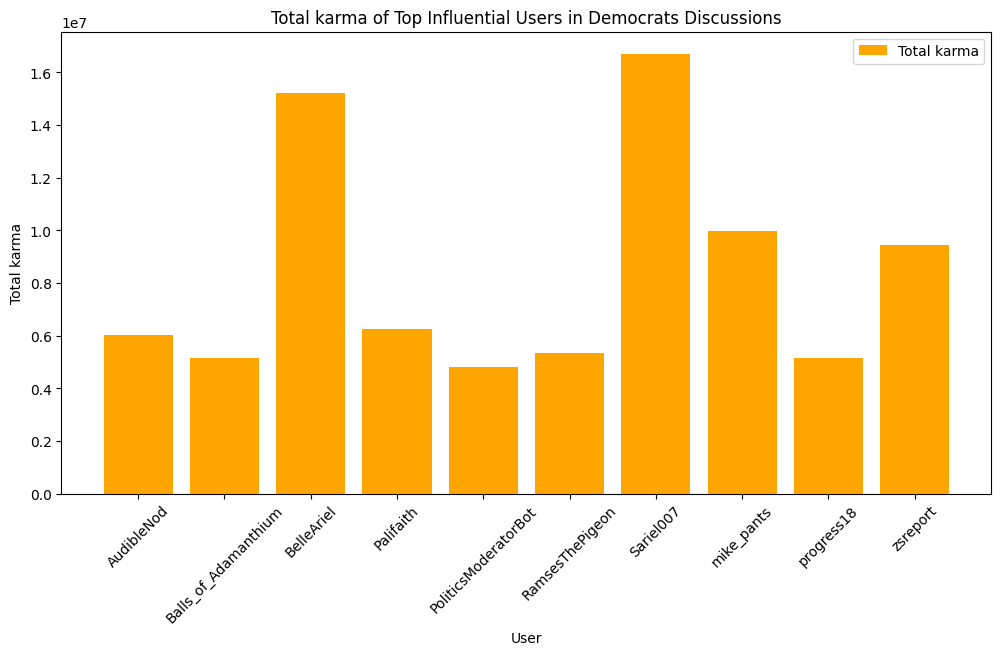

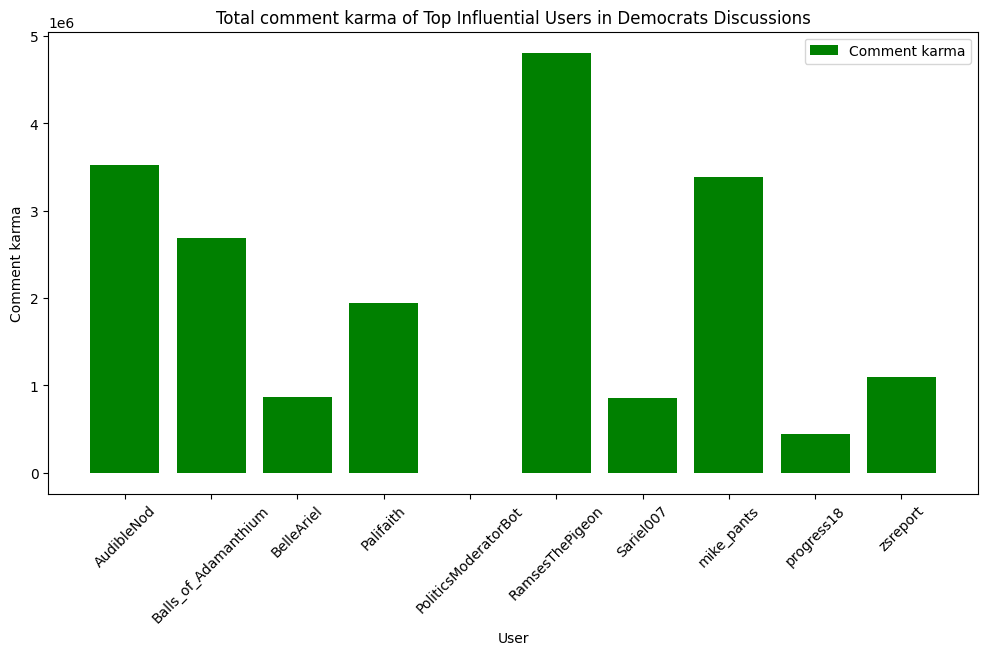

In [ ]:
# Visualize Engagement Patterns for Top Influential Users
# Display engagement patterns
print("\nEngagement Patterns for Top Influential Users:")
print(user_engagement_patterns)

# Bar chart for average upvotes top influential users
plt.figure(figsize=(12, 6))
plt.bar(user_engagement_patterns['author_name'], user_engagement_patterns['ups'], color='skyblue', label='Average Ups')
plt.xlabel("User")
plt.ylabel("Average Engagement")
plt.title("Average Upvotes for Top Influential Users in Democrats Discussions")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Bar chart for total karma of top influential users
plt.figure(figsize=(12, 6))
plt.bar(user_engagement_patterns['author_name'], user_engagement_patterns['user_total_karma'], color='orange', label='Total karma')
plt.xlabel("User")
plt.ylabel("Total karma")
plt.title("Total karma of Top Influential Users in Democrats Discussions")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Bar chart for total comment karma of top influential users
plt.figure(figsize=(12, 6))
plt.bar(user_engagement_patterns['author_name'], user_engagement_patterns['user_comment_karma'], color='green', label='Comment karma')
plt.xlabel("User")
plt.ylabel("Comment karma")
plt.title("Total comment karma of Top Influential Users in Democrats Discussions")
plt.legend()
plt.xticks(rotation=45)
plt.show()

## Using VaderSentiment to explore the data

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
<ipython-input-36-8758b84028e9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_elections_2024_df['user_account_created_time'] = pd.to_datetime(pre_elections_2024_df['user_account_created_time'])
<ipython-input-36-8758b84028e9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_elections_2024_df['account_age_days'] = pre_elections_2024_df['user_account_created_time'].apply(lambda x: (current_date - x).days)
<ipython-input-36-8758b840

Correlation between account age and sentiment score: 0.0108
P-value of the correlation: 0.0000


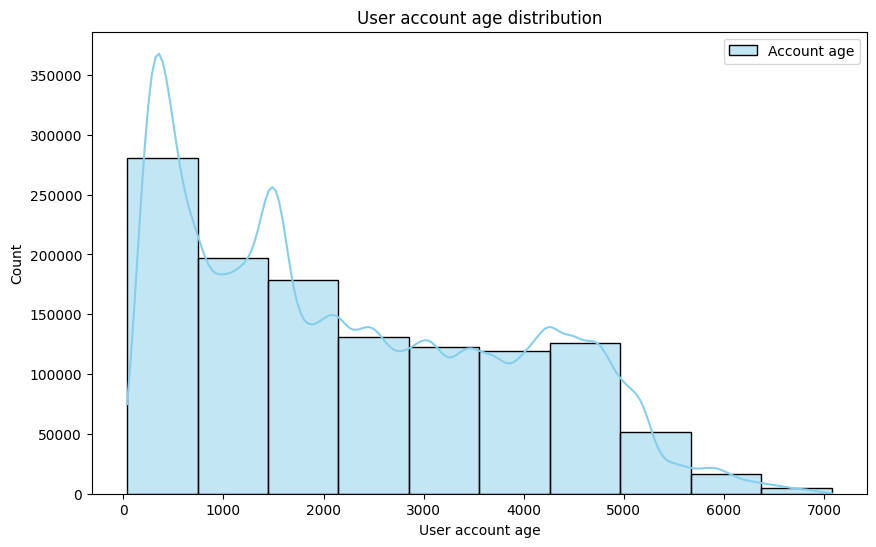

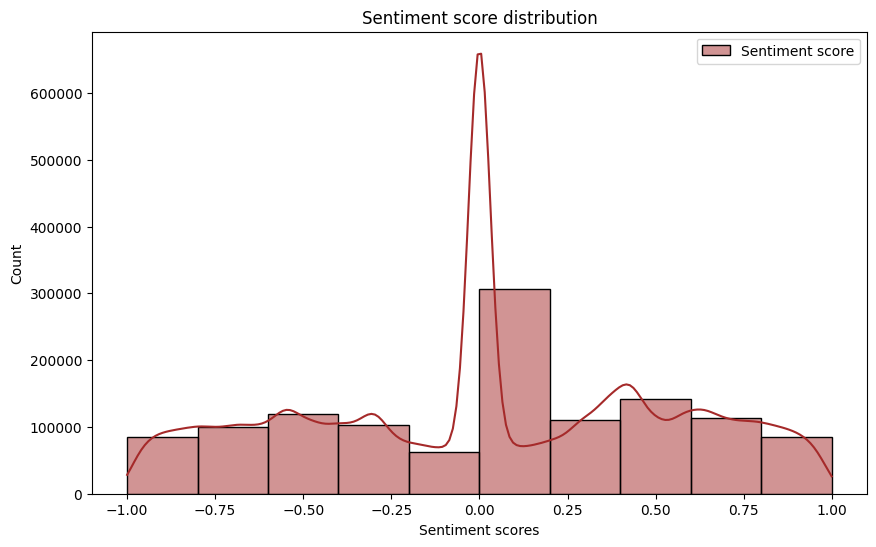

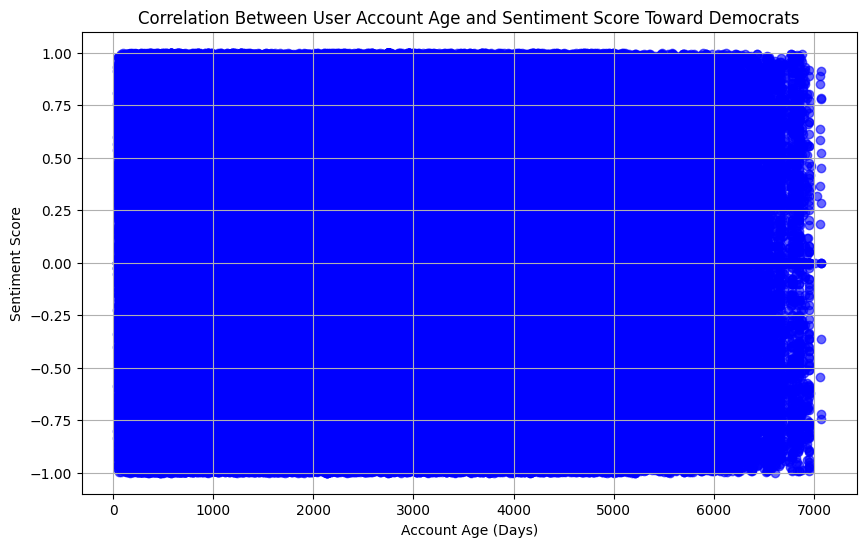

In [ ]:
nltk.download('vader_lexicon')

# Calculate account age in days
current_date = datetime.now()

pre_elections_2024_df['user_account_created_time'] = pd.to_datetime(pre_elections_2024_df['user_account_created_time'])
pre_elections_2024_df['account_age_days'] = pre_elections_2024_df['user_account_created_time'].apply(lambda x: (current_date - x).days)

# Perform Sentiment Analysis
# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment score
def get_sentiment(text):
    if pd.notnull(text):
        sentiment_score = analyzer.polarity_scores(text)['compound']  # compound score for overall sentiment
        return sentiment_score
    return 0

# Apply sentiment analysis to the comments about Republicans
pre_elections_2024_df['sentiment_score'] = pre_elections_2024_df['self_text'].apply(get_sentiment)

# Explore the Correlation Between Account Age and Sentiment Score
# Drop any rows where 'sentiment_score' or 'account_age_days' is missing
pre_elections_2024_df.dropna(subset=['sentiment_score', 'account_age_days'], inplace=True)

# Calculate Pearson correlation coefficient
correlation, p_value = pearsonr(pre_elections_2024_df['account_age_days'], pre_elections_2024_df['sentiment_score'])

# Display results
print(f"Correlation between account age and sentiment score: {correlation:.4f}")
print(f"P-value of the correlation: {p_value:.4f}")

# Distribution of account age
plt.figure(figsize=(10, 6))
sns.histplot(pre_elections_2024_df['account_age_days'], bins=10, kde=True, color='skyblue', label='Account age')
plt.xlabel("User account age")
plt.ylabel("Count")
plt.title("User account age distribution")
plt.legend()
plt.show()

# Distribution of Sentiments
plt.figure(figsize=(10, 6))
sns.histplot(pre_elections_2024_df['sentiment_score'], bins=10, kde=True, color='brown', label='Sentiment score')
plt.xlabel("Sentiment scores")
plt.ylabel("Count")
plt.title("Sentiment score distribution")
plt.legend()
plt.show()

# Visualize the Correlation
plt.figure(figsize=(10, 6))
plt.scatter(pre_elections_2024_df['account_age_days'], pre_elections_2024_df['sentiment_score'], alpha=0.6, color='blue')
plt.xlabel("Account Age (Days)")
plt.ylabel("Sentiment Score")
plt.title("Correlation Between User Account Age and Sentiment Score Toward Democrats")
plt.grid(True)
plt.show()

# Data Cleaning

## Delete initial dataframes to free computational resources

In [ ]:
del df, politics_df, influential_users

## Cleaning the textual data

In [ ]:
# Create Analysis DataFrame

analysis_df = pre_elections_2024_df

analysis_df

,comment_id,score,self_text,subreddit,created_time,post_id,author_name,controversiality,ups,downs,...,post_title,post_upvote_ratio,post_thumbs_ups,post_total_awards_received,post_created_time,day,month,year,account_age_days,sentiment_score
344675,lvfs75p,86,“Go back to (South) Africa!”,politics,2024-11-04 23:59:49,1gjmm0s,JacqueOffAllTrades,0,86,0,...,"Tucker Carlson warns Elon Musk ""will be destroyed"" if Kamala Harris wins",0.92,32653,0,2024-11-04 19:17:36,4,11,2024,253.0,0.0000
344677,lvfs5de,2,I opened the article and was a little dumbstruck. \n\nI guess we will see tomorrow but that’s not great for him,politics,2024-11-04 23:59:32,1gjg7tn,anonononnnnnaaan,0,2,0,...,Donald Trump's Hometown Stronghold Endorses Kamala Harris,0.97,3100,0,2024-11-04 14:57:53,4,11,2024,2405.0,-0.6998
344679,lvfs4zb,2,panicky detail profit abundant slimy shocking boat obtainable dazzling psychotic\n\n *This post was mass deleted and anonymized with [Redact](https://redact.dev/home)*,politics,2024-11-04 23:59:28,1gjjbph,DastardDante,0,2,0,...,Biden Ends 2024 Race Having Done Just One Campaign Event with Harris,0.18,0,0,2024-11-04 17:05:29,4,11,2024,276.0,-0.3182
344682,lvfs45n,13,"Don't forget honorary, irrelevance chorus member Megyn Kelly.",politics,2024-11-04 23:59:20,1gjmm0s,MoreMetaFeta,0,13,0,...,"Tucker Carlson warns Elon Musk ""will be destroyed"" if Kamala Harris wins",0.92,32653,0,2024-11-04 19:17:36,4,11,2024,975.0,-0.0951
344684,lvfs2o3,12,"I still need to watch the Buttigieg video sometime, but on the topic of Obama not codifying Roe, I think there is something he said that critics like to point out about it not being a priority. The thing about it was I'm sure he would have signed it into law if a bill arrived on his desk, but it wasn't likely. So the priority was weighing how much political capital he wanted to use on something (a bunch of democrats in congress would have been really reluctant or outright opposed to it).",politics,2024-11-04 23:59:06,1gjm3v4,hard-time-on-planet,0,12,0,...,Pete Buttigieg debates 25 undecided Michigan voters on why Kamala Harris is better,0.98,5041,0,2024-11-04 18:57:26,4,11,2024,2863.0,0.1181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3168838,kfrpi9g,43,“But food companies who want Trump to win keep gouging prices why won’t Biden do anything it’s his economy! Also if he tried to do anything I’d call him a dirty commie”- way too many Americans,politics,2024-01-01 00:04:17,18vkep6,tinoynk,0,43,0,...,2023 Has Been A Historic Year For American Manufacturing Thanks To Democrats’ Inflation Reduction Act,0.95,2527,0,2023-12-31 23:56:49,1,1,2024,3336.0,0.3595
3168839,kfrpgys,5,&gt; has funded\n\nU.S. since the beginning of Israel — not any one president.\n\nI do not want any Republican having access to a further war chest like this imperialist country and the war lobby for Iran and WW3\n\n/uj peace is possible and it sure as fuck isn’t with anyone right-leaning.,politics,2024-01-01 00:04:02,18v1a01,alexiswithoutthes,0,5,0,...,Muslim leaders expand campaign to abandon Biden in 2024 over Israel-Hamas war,0.37,0,0,2023-12-31 06:16:59,1,1,2024,3062.0,-0.6276
3168841,kfrpf3o,2,"There are multiple claimants to the government of ""Palestine"", and one has dominance in each region. That's exactly the kind of stable outcome that a three State solution would reinforce.",politics,2024-01-01 00:03:41,18v65fh,Fully_Edged_Ken_3685,0,2,0,...,Virginia senator Tim Kaine condemns Biden’s arms transfer to Israel,0.80,340,0,2023-12-31 11:44:51,1,1,2024,352.0,0.6133
3168842,kfrpe6u,1,"It can and will happen, whether it's 2025, 2029, or 2033.\n\nThey at least had the decency to write their plan down for us: https://en.wikipedia.org/wiki/Project_2025",politics,2024-01-01 00:03:31,18v9w8r,vc6vWHzrHvb2PY2LyP6b,0,1,0,...,"Former Trump White House insiders call possible 2nd term a threat to American democracy | ""We don't need to speculate,"" one told ""This Week"" co-anchor Jonathan Karl

In [ ]:
# Load spaCy's small English model
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    # Step 1: Convert to string if not already
    if not isinstance(text, str):
        text = str(text)

    # Step 2: Remove markdown and URLs
    text = re.sub(r'\!\[.*?\]\(.*?\)|https?://\S+|www\.\S+', '', text)

    # Step 3: Remove extra line breaks and normalize whitespace
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Step 4: Remove HTML encodings like '&gt;' and '&amp;'
    text = re.sub(r"&\w+;", "", text)

    return text

analysis_df['clean_text'] = analysis_df['self_text'].apply(preprocess_text)

In [ ]:
analysis_df[['self_text', 'clean_text']]

,self_text,clean_text
344675,“Go back to (South) Africa!”,“Go back to (South) Africa!”
344677,I opened the article and was a little dumbstruck. \n\nI guess we will see tomorrow but that’s not great for him,I opened the article and was a little dumbstruck. I guess we will see tomorrow but that’s not great for him
344679,panicky detail profit abundant slimy shocking boat obtainable dazzling psychotic\n\n *This post was mass deleted and anonymized with [Redact](https://redact.dev/home)*,panicky detail profit abundant slimy shocking boat obtainable dazzling psychotic *This post was mass deleted and anonymized with [Redact](
344682,"Don't forget honorary, irrelevance chorus member Megyn Kelly.","Don't forget honorary, irrelevance chorus member Megyn Kelly."
344684,"I still need to watch the Buttigieg video sometime, but on the topic of Obama not codifying Roe, I think there is something he said that critics like to point out about it not being a priority. The thing about it was I'm sure he would have signed it into law if a bill arrived on his desk, but it wasn't likely. So the priority was weighing how much political capital he wanted to use on something (a bunch of democrats in congress would have been really reluctant or outright opposed to it).","I still need to watch the Buttigieg video sometime, but on the topic of Obama not codifying Roe, I think there is something he said that critics like to point out about it not being a priority. The thing about it was I'm sure he would have signed it into law if a bill arrived on his desk, but it wasn't likely. So the priority was weighing how much political capital he wanted to use on something (a bunch of democrats in congress would have been really reluctant or outright opposed to it)."
...,...,...
3168838,“But food companies who want Trump to win keep gouging prices why won’t Biden do anything it’s his economy! Also if he tried to do anything I’d call him a dirty commie”- way too many Americans,“But food companies who want Trump to win keep gouging prices why won’t Biden do anything it’s his economy! Also if he tried to do anything I’d call him a dirty commie”- way too many Americans
3168839,&gt; has funded\n\nU.S. since the beginning of Israel — not any one president.\n\nI do not want any Republican having access to a further war chest like this imperialist country and the war lobby for Iran and WW3\n\n/uj peace is possible and it sure as fuck isn’t with anyone right-leaning.,has funded U.S. since the beginning of Israel — not any one president. I do not want any Republican having access to a further war chest like this imperialist country and the war lobby for Iran and WW3 /uj peace is possible and it sure as fuck isn’t with anyone right-leaning.
3168841,"There are multiple claimants to the government of ""Palestine"", and one has dominance in each region. That's exactly the kind of stable outcome that a three State solution would reinforce.","There are multiple claimants to the government of ""Palestine"", and one has dominance in each region. That's exactly the kind of stable outcome that a three State solution would reinforce."
3168842,"It can and will happen, whether it's 2025, 2029, or 2033.\n\nThey at least had the decency to write their plan down for us: https://en.wikipedia.org/wiki/Project_2025","It can and will happen, whether it's 2025, 2029, or 2033. They at least had the decency to write their plan down for us:"


## Using VADER for Sentiment Polarity

In [ ]:
# Function to calculate sentiment score
def get_sentiment_polarity(text):
    if pd.notnull(text):
        sentiment_score = analyzer.polarity_scores(text)['compound']  # compound score for overall sentiment
        return sentiment_score
    return 0

# Apply sentiment analysis to the comments about Democrats
analysis_df['vader_sentiment_score'] = analysis_df['clean_text'].apply(get_sentiment_polarity)

In [ ]:
analysis_df['vader_sentiment_score']

,vader_sentiment_score
344675,0.0000
344677,-0.6998
344679,-0.3182
344682,-0.0951
344684,0.1181
...,...
3168838,0.3595
3168839,-0.6276
3168841,0.6133
3168842,0.0000


## Using TextBlob for Sentiment Polarity

In [ ]:
from textblob import TextBlob

# Calculate sentiment polarity
analysis_df['textblob_sentiment_score'] = analysis_df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [ ]:
analysis_df[['clean_text', 'vader_sentiment_score','textblob_sentiment_score']]

,clean_text,vader_sentiment_score,textblob_sentiment_score
344675,“Go back to (South) Africa!”,0.0000,0.000000
344677,I opened the article and was a little dumbstruck. I guess we will see tomorrow but that’s not great for him,-0.6998,-0.293750
344679,panicky detail profit abundant slimy shocking boat obtainable dazzling psychotic *This post was mass deleted and anonymized with [Redact](,-0.3182,-0.037500
344682,"Don't forget honorary, irrelevance chorus member Megyn Kelly.",-0.0951,0.000000
344684,"I still need to watch the Buttigieg video sometime, but on the topic of Obama not codifying Roe, I think there is something he said that critics like to point out about it not being a priority. The thing about it was I'm sure he would have signed it into law if a bill arrived on his desk, but it wasn't likely. So the priority was weighing how much political capital he wanted to use on something (a bunch of democrats in congress would have been really reluctant or outright opposed to it).",0.1181,0.175000
...,...,...,...
3168838,“But food companies who want Trump to win keep gouging prices why won’t Biden do anything it’s his economy! Also if he tried to do anything I’d call him a dirty commie”- way too many Americans,0.3595,0.300000
3168839,has funded U.S. since the beginning of Israel — not any one president. I do not want any Republican having access to a further war chest like this imperialist country and the war lobby for Iran and WW3 /uj peace is possible and it sure as fuck isn’t with anyone right-leaning.,-0.6276,0.025000
3168841,"There are multiple claimants to the government of ""Palestine"", and one has dominance in each region. That's exactly the kind of stable outcome that a three State solution would reinforce.",0.6133,0.283333
3168842,"It can and will happen, whether it's 2025, 2029, or 2033. They at least had the decency to write their plan down for us:",0.0000,-0.227778


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

def tokenize_text(text):
    if not isinstance(text, str):
        return ""

    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = text.lower()  # Convert to lowercase

    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return " ".join(words)

analysis_df['processed_text'] = analysis_df['clean_text'].apply(tokenize_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# LDA for Topic Discovery

In [ ]:
def print_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print("\n")

def calculate_topic_diversity(lda_model, feature_names, top_n=10):
    topic_words = []
    for topic in lda_model.components_:
        top_words = [feature_names[i] for i in topic.argsort()[:-top_n - 1:-1]]
        topic_words.append(set(top_words))

    n_topics = len(topic_words)
    total_pairs = n_topics * (n_topics - 1) / 2
    diversity = 0
    for i in range(n_topics):
        for j in range(i + 1, n_topics):
            diversity += len(topic_words[i].intersection(topic_words[j])) / top_n
    return 1 - (diversity / total_pairs)

def create_lda_model(n_topics, vectorizer, processed_text):

  lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)

  keywords = vectorizer.fit_transform(processed_text)
  lda.fit(keywords)

  # Get the words corresponding to the topics
  feature_names = vectorizer.get_feature_names_out()

  n_top_words = 10  # Number of top words per topic
  print_topics(lda, feature_names, n_top_words)

  topic_distributions = lda.transform(keywords)  # (n_docs, n_topics)

  return lda, keywords, topic_distributions

def print_metrics(lda_model, keywords):
  perplexity = lda_model.perplexity(keywords)
  print(f"Perplexity: {perplexity}")

  log_likelihood = lda_model.score(keywords)
  print(f"Log-Likelihood: {log_likelihood}")

def get_silohouette_score(lda_model, topic_distributions, keywords):
  topic_distributions = lda_model.transform(keywords)  # (n_docs, n_topics)
  silhouette = silhouette_score(topic_distributions, np.argmax(topic_distributions, axis=1))
  print(f"Silhouette Score: {silhouette:.2f}")

## CountVectorizer

In [ ]:
# Vectorize text
vectorizer = CountVectorizer(max_features=1000, stop_words='english')

### 5 topics

#### Train the model
Training the model takes about 1 hour

In [ ]:
lda, keywords, topic_distributions = create_lda_model(5, vectorizer, analysis_df['processed_text'])

Topic #1:
israel people want country trump war court fuck right state


Topic #2:
trump biden vote election voter candidate win harris party democrat


Topic #3:
like people dont think know thats trump thing im say


Topic #4:
year time president trump im got day said old didnt


Topic #5:
news republican biden house good need policy right make issue




In [ ]:
print_metrics(lda, keywords)

Perplexity: 613.849881725981
Log-Likelihood: -80283870.67622739


In [ ]:
# Add dominant topic to the DataFrame
analysis_df['cv5_dominant_topic'] = topic_distributions.argmax(axis=1)
analysis_df[['self_text', 'cv5_dominant_topic']]

,self_text,cv5_dominant_topic
344675,“Go back to (South) Africa!”,3
344677,I opened the article and was a little dumbstruck. \n\nI guess we will see tomorrow but that’s not great for him,2
344679,panicky detail profit abundant slimy shocking boat obtainable dazzling psychotic\n\n *This post was mass deleted and anonymized with [Redact](https://redact.dev/home)*,4
344682,"Don't forget honorary, irrelevance chorus member Megyn Kelly.",4
344684,"I still need to watch the Buttigieg video sometime, but on the topic of Obama not codifying Roe, I think there is something he said that critics like to point out about it not being a priority. The thing about it was I'm sure he would have signed it into law if a bill arrived on his desk, but it wasn't likely. So the priority was weighing how much political capital he wanted to use on something (a bunch of democrats in congress would have been really reluctant or outright opposed to it).",2
...,...,...
3168838,“But food companies who want Trump to win keep gouging prices why won’t Biden do anything it’s his economy! Also if he tried to do anything I’d call him a dirty commie”- way too many Americans,4
3168839,&gt; has funded\n\nU.S. since the beginning of Israel — not any one president.\n\nI do not want any Republican having access to a further war chest like this imperialist country and the war lobby for Iran and WW3\n\n/uj peace is possible and it sure as fuck isn’t with anyone right-leaning.,0
3168841,"There are multiple claimants to the government of ""Palestine"", and one has dominance in each region. That's exactly the kind of stable outcome that a three State solution would reinforce.",0
3168842,"It can and will happen, whether it's 2025, 2029, or 2033.\n\nThey at least had the decency to write their plan down for us: https://en.wikipedia.org/wiki/Project_2025",4


In [ ]:
# get_silohouette_score(lda, topic_distributions, keywords)

In [ ]:
# topic_diversity = calculate_topic_diversity(lda, feature_names, top_n=10)
# print(f"Topic Diversity: {topic_diversity:.2f}")

### 10 topics

#### Train the model
Training the model takes about 1 hour

In [ ]:
lda_2, keywords_2, topic_distributions_2 = create_lda_model(10, vectorizer, analysis_df['processed_text'])

Topic #1:
want court dont law power people country republican fucking government


Topic #2:
biden trump candidate debate win harris going joe kamala vote


Topic #3:
like people dont think thats know thing say im right


Topic #4:
year president time campaign day ago harris week didnt obama


Topic #5:
house news right border republican congress issue fox biden project


Topic #6:
medium good im article fuck really question great people doesnt


Topic #7:
trump said maga thought donald american world supporter shes country


Topic #8:
man old yes got guy need money tax make god


Topic #9:
israel people woman war black support hamas gaza palestinian child


Topic #10:
vote voter republican election state party democrat poll voting trump




In [ ]:
print_metrics(lda_2, keywords_2)

Perplexity: 638.5059958663688
Log-Likelihood: -80776355.83793725


In [ ]:
# get_silohouette_score(lda_2, topic_distributions_2, keywords_2)

In [ ]:
# Add dominant topic to the DataFrame
analysis_df['cv10_dominant_topic'] = topic_distributions_2.argmax(axis=1)
analysis_df[['self_text', 'cv10_dominant_topic']]

,self_text,cv10_dominant_topic
344675,“Go back to (South) Africa!”,8
344677,I opened the article and was a little dumbstruck. \n\nI guess we will see tomorrow but that’s not great for him,5
344679,panicky detail profit abundant slimy shocking boat obtainable dazzling psychotic\n\n *This post was mass deleted and anonymized with [Redact](https://redact.dev/home)*,5
344682,"Don't forget honorary, irrelevance chorus member Megyn Kelly.",4
344684,"I still need to watch the Buttigieg video sometime, but on the topic of Obama not codifying Roe, I think there is something he said that critics like to point out about it not being a priority. The thing about it was I'm sure he would have signed it into law if a bill arrived on his desk, but it wasn't likely. So the priority was weighing how much political capital he wanted to use on something (a bunch of democrats in congress would have been really reluctant or outright opposed to it).",2
...,...,...
3168838,“But food companies who want Trump to win keep gouging prices why won’t Biden do anything it’s his economy! Also if he tried to do anything I’d call him a dirty commie”- way too many Americans,4
3168839,&gt; has funded\n\nU.S. since the beginning of Israel — not any one president.\n\nI do not want any Republican having access to a further war chest like this imperialist country and the war lobby for Iran and WW3\n\n/uj peace is possible and it sure as fuck isn’t with anyone right-leaning.,8
3168841,"There are multiple claimants to the government of ""Palestine"", and one has dominance in each region. That's exactly the kind of stable outcome that a three State solution would reinforce.",8
3168842,"It can and will happen, whether it's 2025, 2029, or 2033.\n\nThey at least had the decency to write their plan down for us: https://en.wikipedia.org/wiki/Project_2025",7


## TfidfVectorizer

In [ ]:
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')

### 5 topics

#### Train the model
Training the model takes about 55 minutes

In [ ]:
tfidf_lda, tfidf_keywords, tfidf_topic_distributions = create_lda_model(5, tfidf, analysis_df['processed_text'])

Topic #1:
israel trump court fuck war people want law country hamas


Topic #2:
vote trump biden election win candidate harris voter party democrat


Topic #3:
like people dont trump thats think know say thing youre


Topic #4:
im year trump time old biden president got like day


Topic #5:
good news people right dont fox like republican trump house




In [ ]:
print_metrics(tfidf_lda, tfidf_keywords)

Perplexity: 1255.9299027675672
Log-Likelihood: -22134691.144161906


In [ ]:
# get_silohouette_score(tfidf_lda, tfidf_topic_distributions, tfidf_keywords)

In [ ]:
# Add dominant topic to the DataFrame
analysis_df['tf5_dominant_topic'] = tfidf_topic_distributions.argmax(axis=1)
analysis_df[['self_text', 'tf5_dominant_topic']]

,self_text,tf5_dominant_topic
344675,“Go back to (South) Africa!”,3
344677,I opened the article and was a little dumbstruck. \n\nI guess we will see tomorrow but that’s not great for him,2
344679,panicky detail profit abundant slimy shocking boat obtainable dazzling psychotic\n\n *This post was mass deleted and anonymized with [Redact](https://redact.dev/home)*,4
344682,"Don't forget honorary, irrelevance chorus member Megyn Kelly.",4
344684,"I still need to watch the Buttigieg video sometime, but on the topic of Obama not codifying Roe, I think there is something he said that critics like to point out about it not being a priority. The thing about it was I'm sure he would have signed it into law if a bill arrived on his desk, but it wasn't likely. So the priority was weighing how much political capital he wanted to use on something (a bunch of democrats in congress would have been really reluctant or outright opposed to it).",2
...,...,...
3168838,“But food companies who want Trump to win keep gouging prices why won’t Biden do anything it’s his economy! Also if he tried to do anything I’d call him a dirty commie”- way too many Americans,4
3168839,&gt; has funded\n\nU.S. since the beginning of Israel — not any one president.\n\nI do not want any Republican having access to a further war chest like this imperialist country and the war lobby for Iran and WW3\n\n/uj peace is possible and it sure as fuck isn’t with anyone right-leaning.,0
3168841,"There are multiple claimants to the government of ""Palestine"", and one has dominance in each region. That's exactly the kind of stable outcome that a three State solution would reinforce.",0
3168842,"It can and will happen, whether it's 2025, 2029, or 2033.\n\nThey at least had the decency to write their plan down for us: https://en.wikipedia.org/wiki/Project_2025",4


### 10 topics

#### Train the model
Training the model takes about 49 minutes

In [ ]:
tfidf_lda_2, tfidf_keywords_2, tfidf_topic_distributions_2 = create_lda_model(10, tfidf, analysis_df['processed_text'])

Topic #1:
israel court war hamas trump law gaza supreme genocide palestinian


Topic #2:
biden trump candidate harris debate win kamala going think joe


Topic #3:
like thats say know trump weird comment youre people dont


Topic #4:
year im president time trump sure biden day ago wait


Topic #5:
news right fox house yeah border ok mean let dont


Topic #6:
fuck good article medium trump question great man answer people


Topic #7:
trump thought said shes like ive seen biden people nice


Topic #8:
yes people god like dont gun country damn trump want


Topic #9:
people woman black guy hate trump like theyre word make


Topic #10:
vote poll voter republican state trump election party democrat dont




In [ ]:
print_metrics(tfidf_lda_2, tfidf_keywords_2)

Perplexity: 1641.0416505069313
Log-Likelihood: -22964334.93700885


In [ ]:
# get_silohouette_score(tfidf_lda_2, tfidf_topic_distributions_2, tfidf_keywords_2)

In [ ]:
# Add dominant topic to the DataFrame
analysis_df['tf10_dominant_topic'] = tfidf_topic_distributions_2.argmax(axis=1)
analysis_df[['self_text', 'tf10_dominant_topic']]

,self_text,tf10_dominant_topic
344675,“Go back to (South) Africa!”,3
344677,I opened the article and was a little dumbstruck. \n\nI guess we will see tomorrow but that’s not great for him,5
344679,panicky detail profit abundant slimy shocking boat obtainable dazzling psychotic\n\n *This post was mass deleted and anonymized with [Redact](https://redact.dev/home)*,7
344682,"Don't forget honorary, irrelevance chorus member Megyn Kelly.",4
344684,"I still need to watch the Buttigieg video sometime, but on the topic of Obama not codifying Roe, I think there is something he said that critics like to point out about it not being a priority. The thing about it was I'm sure he would have signed it into law if a bill arrived on his desk, but it wasn't likely. So the priority was weighing how much political capital he wanted to use on something (a bunch of democrats in congress would have been really reluctant or outright opposed to it).",2
...,...,...
3168838,“But food companies who want Trump to win keep gouging prices why won’t Biden do anything it’s his economy! Also if he tried to do anything I’d call him a dirty commie”- way too many Americans,5
3168839,&gt; has funded\n\nU.S. since the beginning of Israel — not any one president.\n\nI do not want any Republican having access to a further war chest like this imperialist country and the war lobby for Iran and WW3\n\n/uj peace is possible and it sure as fuck isn’t with anyone right-leaning.,0
3168841,"There are multiple claimants to the government of ""Palestine"", and one has dominance in each region. That's exactly the kind of stable outcome that a three State solution would reinforce.",0
3168842,"It can and will happen, whether it's 2025, 2029, or 2033.\n\nThey at least had the decency to write their plan down for us: https://en.wikipedia.org/wiki/Project_2025",7


# K-Means Clustering


## TfidfVectorizer

In [ ]:
# Convert text to numerical representation using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(analysis_df['processed_text'])

### 5 Clusters

In [ ]:
# Apply K-Means clustering
num_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Assign cluster labels to the DataFrame
analysis_df['cluster_tf5'] = kmeans.labels_

In [ ]:
# Evaluate clustering

inertia = kmeans.inertia_
print(f"Inertia: {inertia}")

kmeans_score = kmeans.score(tfidf_matrix)
print(f"Score: {kmeans_score}")

Inertia: 1199974.6220844628
Score: -1199974.6220844628


### 10 Clusters

In [ ]:
num_clusters = 10  # Define the number of clusters
kmeans10 = KMeans(n_clusters=num_clusters, random_state=42)
kmeans10.fit(tfidf_matrix)

# Assign cluster labels to the DataFrame
analysis_df['cluster_tf10'] = kmeans10.labels_

In [ ]:
# Evaluate clustering

inertia = kmeans10.inertia_
print(f"Inertia: {inertia}")

kmeans10_score = kmeans10.score(tfidf_matrix)
print(f"Score: {kmeans10_score}")

Inertia: 1192630.2581096848
Score: -1192630.2581096848


## CountVectorizer

In [ ]:
# Convert text to numerical representation using CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')
count_matrix = count_vectorizer.fit_transform(analysis_df['processed_text'])

### 5 Clusters

In [ ]:
# Apply K-Means clustering
num_clusters = 5  # Define the number of clusters
kmeans_cv5 = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_cv5.fit(count_matrix)

# Assign cluster labels to the DataFrame
analysis_df['cluster_cv5'] = kmeans_cv5.labels_

In [ ]:
inertia = kmeans_cv5.inertia_
print(f"Inertia: {inertia}")

Inertia: 24509944.741382003


### 10 Clusters

In [ ]:
num_clusters = 10  # Define the number of clusters
kmeans_cv10 = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_cv10.fit(tfidf_matrix)

# Assign cluster labels to the DataFrame
analysis_df['cluster_cv10'] = kmeans_cv10.labels_

In [ ]:
inertia = kmeans_cv10.inertia_
print(f"Inertia: {inertia}")

Inertia: 1192630.2581096848


# Qualitative Analysis

In [ ]:
# Function to calculate sentiment score
def get_sentiment(sentiment_score):
  if sentiment_score >= 0.0765:    # Best decision boundary = 0.0765
    return "positive"
  elif sentiment_score <= -0.0765:
    return "negative"
  else:
    return "neutral"

analysis_df['vader_sentiment'] = analysis_df['vader_sentiment_score'].apply(get_sentiment)

In [ ]:
topic_distribution = analysis_df['tf5_dominant_topic'].value_counts()
topic_distribution

,count
tf5_dominant_topic,
1,293110
2,268071
0,253817
3,220007
4,192281


In [ ]:
# Engagement Analysis
engagement_stats = analysis_df.groupby('tf5_dominant_topic')[['score', 'ups', 'downs']].mean()

# Time-based Analysis
analysis_df['post_created_time'] = pd.to_datetime(analysis_df['post_created_time'])
analysis_df['hour'] = analysis_df['post_created_time'].dt.hour
hourly_activity = analysis_df.groupby('hour').size()

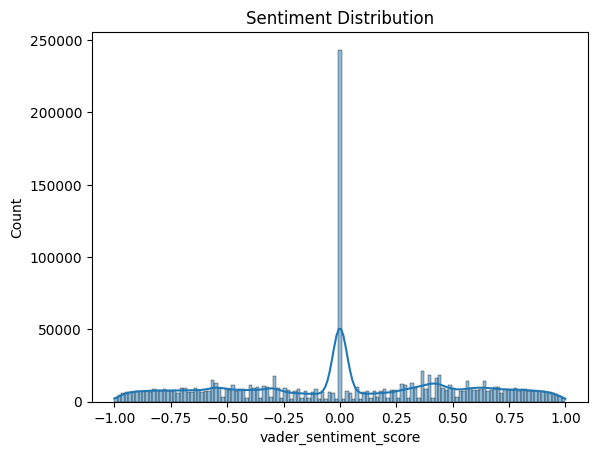

In [ ]:
sns.histplot(analysis_df['vader_sentiment_score'], kde=True)
plt.title("Sentiment Distribution")
plt.show()

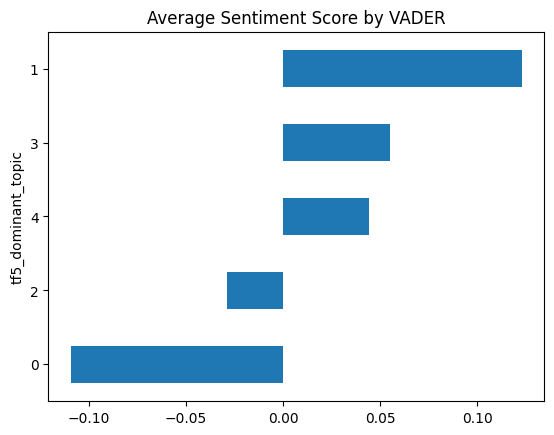

In [ ]:
analysis_df.groupby('tf5_dominant_topic')['vader_sentiment_score'].mean().sort_values().plot(kind='barh')
plt.title("Average Sentiment Score by VADER")
plt.show()

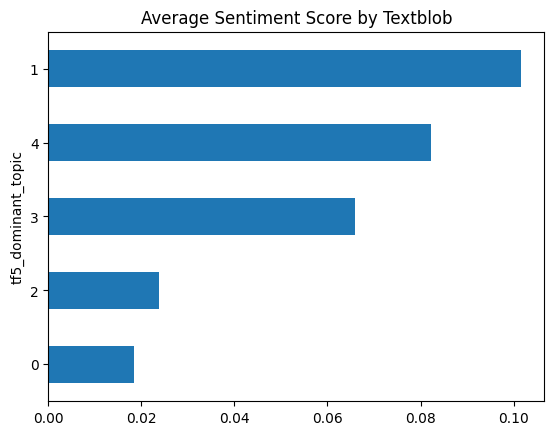

In [ ]:
analysis_df.groupby('tf5_dominant_topic')['textblob_sentiment_score'].mean().sort_values().plot(kind='barh')
plt.title("Average Sentiment Score by Textblob")
plt.show()

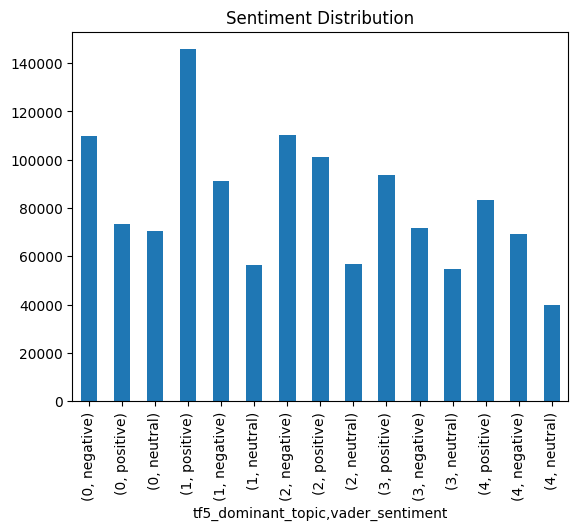

In [ ]:
analysis_df.groupby('tf5_dominant_topic')['vader_sentiment'].value_counts().plot(kind='bar')
plt.title("Sentiment Distribution")
plt.show()

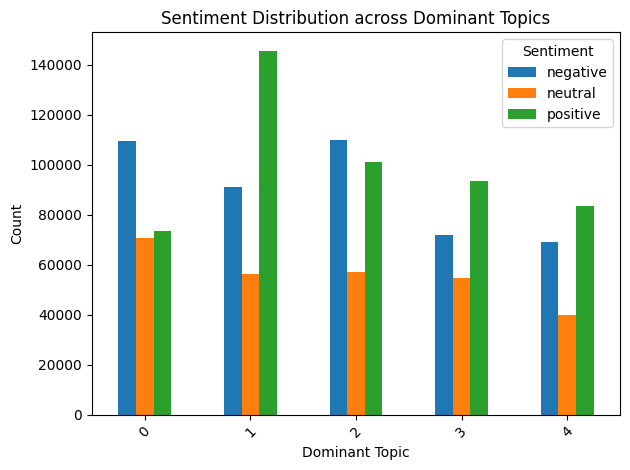

In [ ]:
# Create the multi-bar graph
ax = analysis_df.groupby('tf5_dominant_topic')['vader_sentiment'].value_counts().unstack().plot(kind='bar')
plt.title('Sentiment Distribution across Dominant Topics')
plt.xlabel('Dominant Topic')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')

plt.tight_layout()
plt.show()

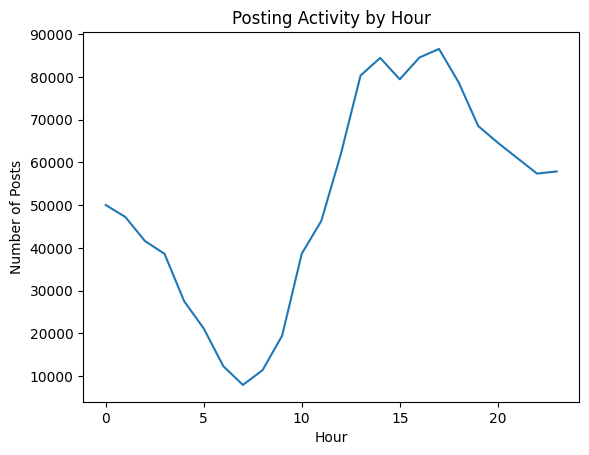

In [ ]:
hourly_activity.plot(kind='line')
plt.title("Posting Activity by Hour")
plt.xlabel("Hour")
plt.ylabel("Number of Posts")
plt.show()

In [ ]:
analysis_df['post_created_time'] = pd.to_datetime(analysis_df['post_created_time'])
analysis_df['time_from_election_day'] = round((pd.to_datetime('2024-11-05 00:00:00') - analysis_df['post_created_time']).dt.days / 30, 0)
analysis_df['time_from_election_day'] = analysis_df['time_from_election_day'].astype(int)

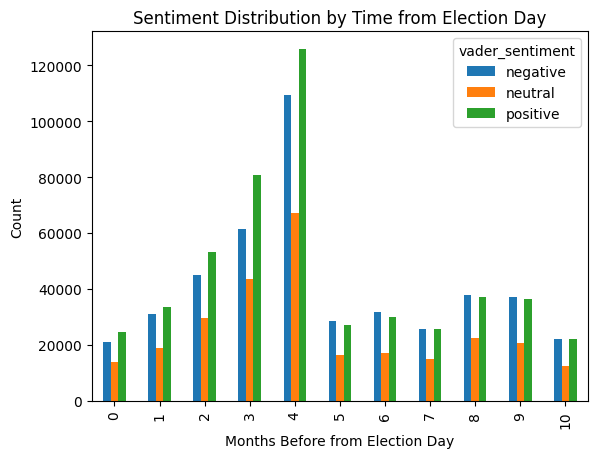

<Figure size 1500x1000 with 0 Axes>

In [ ]:
analysis_df.groupby('time_from_election_day')['vader_sentiment'].value_counts().nlargest(50).unstack().plot(kind='bar')
plt.title("Sentiment Distribution by Time from Election Day")
plt.xlabel("Months Before from Election Day")
plt.ylabel("Count")
plt.figure(figsize=(15, 10))
plt.show()

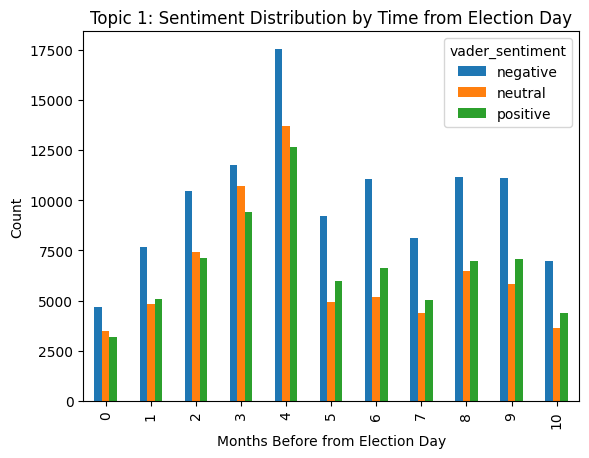

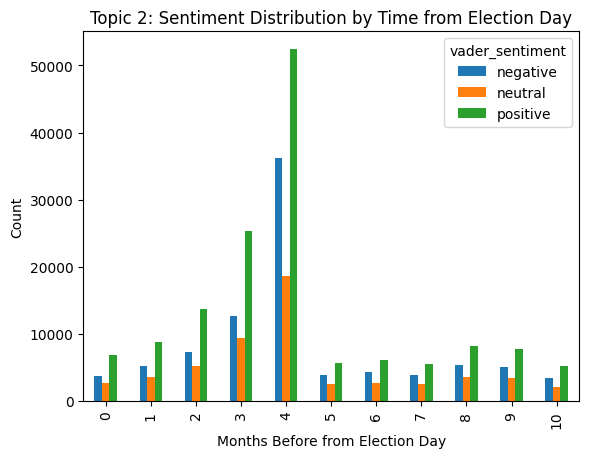

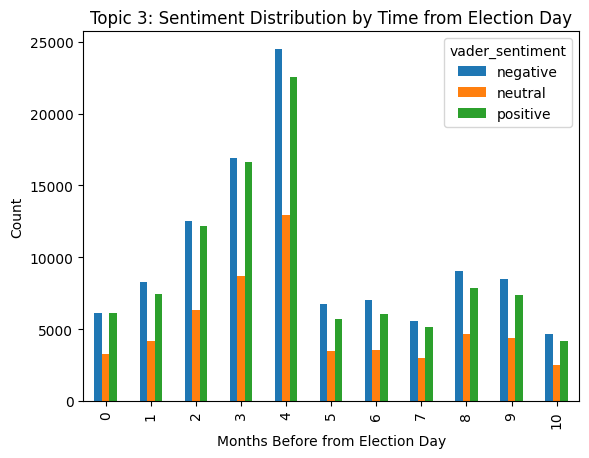

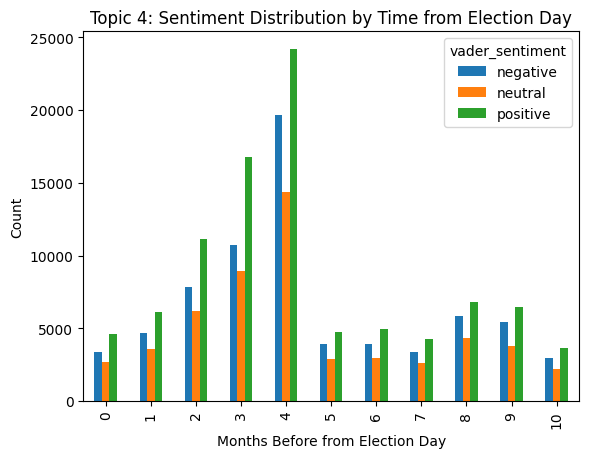

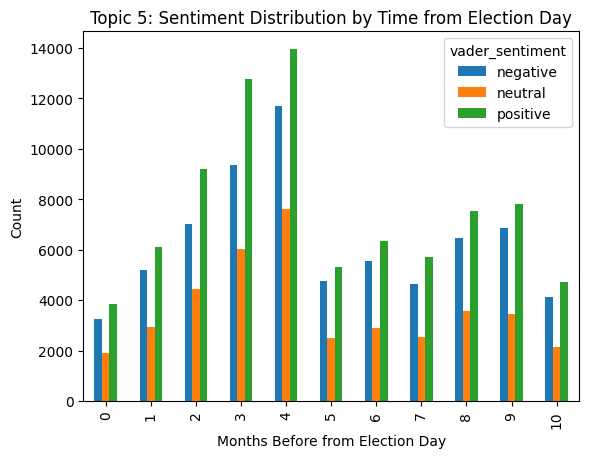

In [ ]:
for i in range(5):
  analysis_df[analysis_df['tf5_dominant_topic'] == i].groupby('time_from_election_day')['vader_sentiment'].value_counts().nlargest(50).unstack().plot(kind='bar')
  plt.title(f"Topic {i+1}: Sentiment Distribution by Time from Election Day")
  plt.xlabel("Months Before from Election Day")
  plt.ylabel("Count")
  plt.show()

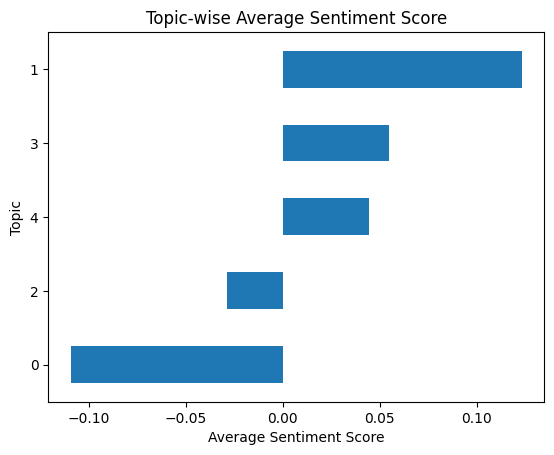

In [ ]:
analysis_df.groupby('tf5_dominant_topic')['vader_sentiment_score'].mean().sort_values().plot(kind='barh')
plt.title("Topic-wise Average Sentiment Score")
plt.xlabel("Average Sentiment Score")
plt.ylabel("Topic")
plt.show()

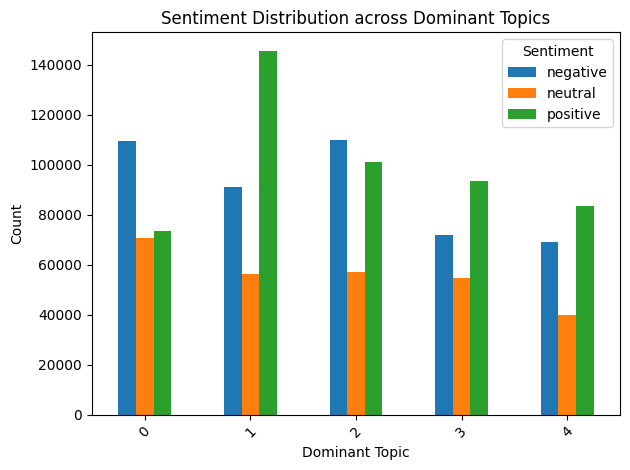

In [ ]:
# Multi-bar graph
ax = analysis_df.groupby('tf5_dominant_topic')['vader_sentiment'].value_counts().unstack().plot(kind='bar')
plt.title('Sentiment Distribution across Dominant Topics')
plt.xlabel('Dominant Topic')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')

plt.tight_layout()
plt.show()

# Save final dataframe

In [ ]:
# analysis_df.to_csv(DATASETS_PATH + "/final_democrats-analysis_df.csv", index=False)

# Most Commonly Used Phrases Across Topics

In [ ]:
# define analysis window for month august
engaging_month = analysis_df[(analysis_df['month'] == 7)]

# Function to get most common phrases
def get_most_common_phrases(comments, ngram_range, top_n):
    comments = [str(comment) if not pd.isnull(comment) else '' for comment in comments]
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    bag_of_words = vectorizer.fit_transform(comments)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_n]

# Most common phrases per topic
topic_phrases = {}
for topic in engaging_month["tf5_dominant_topic"].unique():
    topic_comments = engaging_month[engaging_month["tf5_dominant_topic"] == topic]["clean_text"].tolist()
    topic_phrases[topic] = get_most_common_phrases(topic_comments, ngram_range=(3, 5), top_n=10)

# Print most common phrases for each topic
for topic, phrases in topic_phrases.items():
    print(f"\nTopic {topic} Most Common Phrases:")
    for phrase, freq in phrases:
        print(f"{phrase}:{freq}")


Topic 2 Most Common Phrases:
new york times: 80
right wing media: 76
people don like: 58
agree notch rhetoric: 57
notch rhetoric agree: 57
rhetoric agree use: 57
agree use analogy: 57
use analogy continue: 57
analogy continue rhetoric: 57
continue rhetoric way: 57

Topic 3 Most Common Phrases:
81 year old: 190
vice president trump: 114
year old man: 101
president united states: 90
80 year old: 88
president joe biden: 86
long time ago: 73
just bad night: 61
13 year old: 59
78 year old: 54

Topic 1 Most Common Phrases:
biden step aside: 477
vote blue matter: 344
president joe biden: 231
president kamala harris: 215
biden steps aside: 192
vice president kamala: 189
vice president kamala harris: 188
swing state voters: 183
needs step aside: 183
won popular vote: 174

Topic 0 Most Common Phrases:
supreme court justices: 181
president united states: 135
convicted felon rapist: 109
supreme court just: 99
supreme court ruling: 79
supreme court justice: 78
ody ody ody: 62
ody ody ody ody: 61
t

# Emotional Sentiment Analysis
This model requires a Hugging Face API token and takes roughly 1.5 hours to run completely.

In [ ]:
# Create a dataframe for the pre-election week
election_week = analysis_df[(analysis_df['created_time'] >= '2024-10-28 00:00:00')
                            & (analysis_df['created_time'] <= '2024-11-04 23:59:59')]

election_week.shape

(33230, 41)

In [ ]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")

emotion_model = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    tokenizer=tokenizer  # Pass the tokenizer to the pipeline
)

# Ensure 'clean_text' column contains strings
election_week['clean_text'] = election_week['clean_text'].astype(str)

# Get emotion labels using the model, pass raw text
# The pipeline handles tokenization internally
emotion_labels = []
for text in election_week['clean_text'].tolist():
    # Truncate the text to the maximum sequence length
    # The tokenizer returns overflowing tokens when text is longer than max_length
    # we take the first set of tokens which represent the truncated text
    encoded_input = tokenizer(text, truncation=True, max_length=512, return_overflowing_tokens=True)
    truncated_text = tokenizer.decode(encoded_input["input_ids"][0], skip_special_tokens=True) # decode the first set of input_ids

    result = emotion_model(truncated_text)
    emotion_labels.extend(result)  # Append results to the list

print(emotion_labels)

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

<ipython-input-87-c4a116b36909>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  election_week['clean_text'] = election_week['clean_text'].astype(str)


model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

[{'label': 'anger', 'score': 0.6611155867576599}, {'label': 'surprise', 'score': 0.7563447952270508}, {'label': 'fear', 'score': 0.52618008852005}, {'label': 'neutral', 'score': 0.8892696499824524}, {'label': 'neutral', 'score': 0.8822794556617737}, {'label': 'disgust', 'score': 0.4987514913082123}, {'label': 'neutral', 'score': 0.7095576524734497}, {'label': 'joy', 'score': 0.8326718807220459}, {'label': 'disgust', 'score': 0.43664899468421936}, {'label': 'surprise', 'score': 0.4533731937408447}, {'label': 'disgust', 'score': 0.5997820496559143}, {'label': 'neutral', 'score': 0.8998872637748718}, {'label': 'neutral', 'score': 0.9563259482383728}, {'label': 'neutral', 'score': 0.9718711972236633}, {'label': 'neutral', 'score': 0.9036178588867188}, {'label': 'neutral', 'score': 0.37396514415740967}, {'label': 'neutral', 'score': 0.6699795126914978}, {'label': 'neutral', 'score': 0.9399100542068481}, {'label': 'anger', 'score': 0.8410841226577759}, {'label': 'joy', 'score': 0.71741569042

In [ ]:
len(emotion_labels)

33230

In [ ]:
election_week['emotion_labels'] = emotion_labels

<ipython-input-107-88ed81533bb4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  election_week['emotion_labels'] = emotion_labels


In [ ]:
# Function to calculate sentiment score
def get_emotion(emotion_labels):
  return emotion_labels['label']

election_week['emotion'] = election_week['emotion_labels'].apply(get_emotion)

<ipython-input-108-ceed2bbdbcba>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  election_week['emotion'] = election_week['emotion_labels'].apply(get_emotion)


Text(0, 0.5, 'Count')

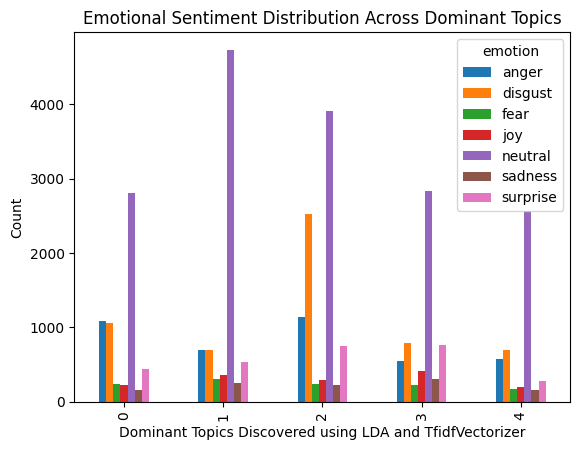

In [ ]:
election_week.groupby('tf5_dominant_topic')['emotion'].value_counts().unstack().plot(kind='bar')
plt.title("Emotional Sentiment Distribution Across Dominant Topics")
plt.xlabel('Dominant Topics Discovered using LDA and TfidfVectorizer')
plt.ylabel('Count')